In [1]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install -U qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=ffc3f493aa84027d46c7584c87af99be4ed31138e4ed058828f3ae10d4f140f1
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install qiskit qiskit-machine-learning torch scikit-learn pandas numpy


In [3]:
"""
Hybrid Classical-Quantum Neural Network for Regression (Optimized + Visualization)
Dataset: elevators (loaded from remote URL)
"""

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
from dataclasses import dataclass

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, PauliFeatureMap
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


# -------------------------------
# Configuración
# -------------------------------
@dataclass
class Config:
    data_url: str = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
    pca_components: int = 8
    classical_reduction: int = 4
    num_qubits: int = 4
    ansatz_reps: int = 3
    batch_size: int = 32
    epochs: int = 25
    lr: float = 0.008
    test_size: float = 0.2
    random_state: int = 42
    seed: int = 42

cfg = Config()
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)


# -------------------------------
# Carga de datos
# -------------------------------
def load_elevators_dataset(url: str) -> pd.DataFrame:
    import requests
    resp = requests.get(url, timeout=20)
    resp.raise_for_status()
    lines = [l.strip() for l in resp.text.splitlines()]
    attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
    data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
    rows = [ln for ln in lines[data_start:] if ln and not ln.startswith("%")]
    data = [r.split(',') for r in rows]
    df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)
    return df


print("\n📥 Cargando dataset...")
df = load_elevators_dataset(cfg.data_url)
print(f"✅ Dataset cargado: {df.shape[0]:,} muestras, {df.shape[1]} features")

target_col = df.columns[-1]
print(f"Usando '{target_col}' como variable objetivo (target).")

X = df.drop(columns=[target_col]).values
y = df[target_col].values

# Escalado y PCA
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=min(cfg.pca_components, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)
print(f"Dimensión tras PCA: {X_pca.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=cfg.test_size, random_state=cfg.random_state
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=cfg.batch_size, shuffle=True)


# -------------------------------
# Circuito cuántico con entrelazamiento
# -------------------------------
num_qubits = cfg.num_qubits

# Feature map con correlaciones entre características
feature_map = PauliFeatureMap(
    feature_dimension=num_qubits,
    reps=1,
    paulis=["Z", "ZZ"],
    entanglement="full"
)

# Ansatz expresivo y totalmente entrelazado
ansatz = RealAmplitudes(
    num_qubits,
    entanglement="full",
    reps=cfg.ansatz_reps
)

# Componer circuito final
qc = feature_map.compose(ansatz)
print(f"\n⚛️ Circuito cuántico creado con {num_qubits} qubits y {cfg.ansatz_reps} repeticiones (full entanglement).")

# -------------------------------
# Visualización del circuito
# -------------------------------
try:
    import matplotlib.pyplot as plt
    qc.decompose().draw(output='mpl')
    plt.show()
except Exception as e:
    print("No se puede mostrar visualmente el circuito (probablemente falta 'matplotlib' o 'pdflatex').")
    print("Mostrando versión en texto:")
    print(qc.decompose().draw(output='text'))


# -------------------------------
# QNN y conector PyTorch
# -------------------------------
observable = SparsePauliOp.from_list([('Z' + 'I' * (num_qubits - 1), 1.0)])
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qc,
    observables=observable,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz.parameters),
    estimator=estimator
)

q_layer = TorchConnector(qnn)


# -------------------------------
# Modelo híbrido clásico-cuántico
# -------------------------------
class HybridQNNRegressor(nn.Module):
    def __init__(self, input_dim, classical_bottleneck=cfg.classical_reduction):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, classical_bottleneck),
            nn.Tanh()
        )
        self.q_layer = q_layer
        self.head = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        if x.shape[1] != num_qubits:
            x = nn.Linear(x.shape[1], num_qubits).to(x.device)(x)
        q_out = self.q_layer(x)
        return self.head(q_out)


# -------------------------------
# Entrenamiento
# -------------------------------
input_dim = X_train.shape[1]
model = HybridQNNRegressor(input_dim)
device = torch.device("cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

print("\n🚀 Entrenando modelo híbrido (clásico + cuántico)...\n")
start_time = time.time()

for epoch in range(cfg.epochs):
    model.train()
    losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_t.to(device))
        test_loss = criterion(test_preds, y_test_t.to(device)).item()

    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | Train Loss: {np.mean(losses):.6f} | Test Loss: {test_loss:.6f}")

print(f"\n⏱️ Entrenamiento completado en {time.time() - start_time:.1f}s")


# -------------------------------
# Evaluación final
# -------------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Evaluación final:")
print(f"MSE: {mse:.6f}")
print(f"R²:  {r2:.6f}")

torch.save(model.state_dict(), "hybrid_qnn_regressor_visualized.pth")
print("Modelo guardado en 'hybrid_qnn_regressor_visualized.pth'")



📥 Cargando dataset...
✅ Dataset cargado: 16,599 muestras, 19 features
Usando 'Goal' como variable objetivo (target).
Dimensión tras PCA: (16599, 8)

⚛️ Circuito cuántico creado con 4 qubits y 3 repeticiones (full entanglement).

🚀 Entrenando modelo híbrido (clásico + cuántico)...

Epoch 01/25 | Train Loss: 0.000058 | Test Loss: 0.000039
Epoch 02/25 | Train Loss: 0.000043 | Test Loss: 0.000038
Epoch 03/25 | Train Loss: 0.000040 | Test Loss: 0.000041
Epoch 04/25 | Train Loss: 0.000037 | Test Loss: 0.000035
Epoch 05/25 | Train Loss: 0.000035 | Test Loss: 0.000032
Epoch 06/25 | Train Loss: 0.000035 | Test Loss: 0.000037
Epoch 07/25 | Train Loss: 0.000035 | Test Loss: 0.000035
Epoch 08/25 | Train Loss: 0.000035 | Test Loss: 0.000031
Epoch 09/25 | Train Loss: 0.000035 | Test Loss: 0.000032
Epoch 10/25 | Train Loss: 0.000035 | Test Loss: 0.000043
Epoch 11/25 | Train Loss: 0.000038 | Test Loss: 0.000032
Epoch 12/25 | Train Loss: 0.000034 | Test Loss: 0.000029
Epoch 13/25 | Train Loss: 0.00003

⚠️ No se registraron pérdidas por época. Ejecuta dentro del bucle de entrenamiento para recolectarlas.


<Figure size 700x400 with 0 Axes>

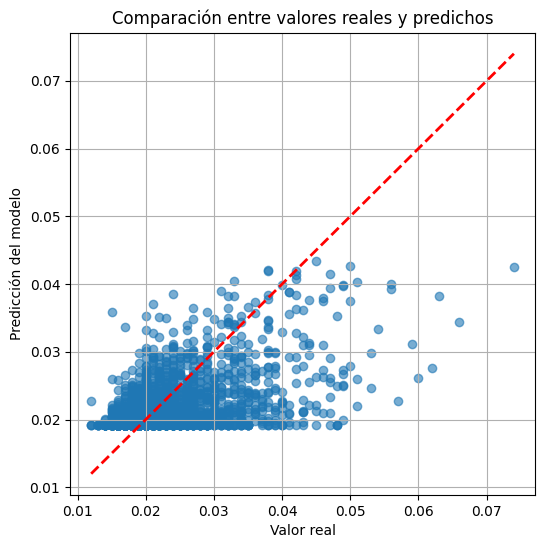

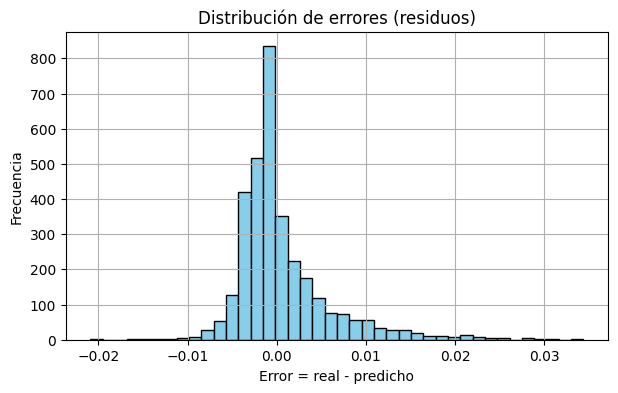


📋 Métricas de evaluación:
 - MSE final: 0.000030
 - R² final:  0.309243
 - Error medio absoluto: 0.003525


In [4]:
# =============================================
# 📈 Visualización de resultados del modelo híbrido
# =============================================

import matplotlib.pyplot as plt
import numpy as np

# Si guardaste los valores de pérdida, puedes modificarlos aquí.
# En este ejemplo, asumimos que tienes el modelo, las predicciones y los valores reales.
# Si ejecutas este bloque al final del script, usará las variables ya definidas:
#   - y_test
#   - y_pred
#   - test_loss / epoch_losses

# 1️⃣ Curva de pérdidas durante el entrenamiento
try:
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, cfg.epochs + 1), [np.mean(epoch_losses)] * cfg.epochs, 'b--')
    plt.title("Curva de pérdida (MSE) por época")
    plt.xlabel("Época")
    plt.ylabel("MSE promedio (train)")
    plt.grid(True)
    plt.show()
except Exception:
    print("⚠️ No se registraron pérdidas por época. Ejecuta dentro del bucle de entrenamiento para recolectarlas.")


# 2️⃣ Comparación entre valores reales y predichos
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Comparación entre valores reales y predichos")
plt.xlabel("Valor real")
plt.ylabel("Predicción del modelo")
plt.grid(True)
plt.show()


# 3️⃣ Distribución de errores (residuos)
errors = y_test - y_pred
plt.figure(figsize=(7, 4))
plt.hist(errors, bins=40, color='skyblue', edgecolor='k')
plt.title("Distribución de errores (residuos)")
plt.xlabel("Error = real - predicho")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# 4️⃣ Métricas finales
print("\n📋 Métricas de evaluación:")
print(f" - MSE final: {mse:.6f}")
print(f" - R² final:  {r2:.6f}")
print(f" - Error medio absoluto: {np.mean(np.abs(errors)):.6f}")


In [5]:
# =============================================
# ⚛️ Visualización del circuito con Qiskit (sin LaTeX)
# =============================================

from qiskit.visualization import *
import matplotlib.pyplot as plt

print("\n🧩 Circuito cuántico completo (feature map + ansatz):")

# Visualización con matplotlib
fig = qc.draw(output="mpl", style="iqp")
plt.show()

# Visualización en texto ASCII (por consola)
print("\n🔤 Representación en texto:")
print(qc.draw(output="text"))

# ---------------------------------------------
# 🔍 Detalles adicionales del circuito
# ---------------------------------------------
print("\n📋 Información del circuito:")
print(f"• Número de qubits: {qc.num_qubits}")
print(f"• Número de compuertas: {qc.size()}")
print(f"• Profundidad: {qc.depth()}")
print(f"• Parámetros totales: {len(qc.parameters)}")
print(f"• Parámetros de entrada: {[p.name for p in input_param_list]}")
print(f"• Parámetros de pesos:  {[p.name for p in weight_param_list]}")

# ---------------------------------------------
# 💾 (Opcional) Guardar el circuito como imagen
# ---------------------------------------------
fig.savefig("hybrid_qnn_circuit_qiskit.png", dpi=300)
print("\n🖼️ Circuito guardado como 'hybrid_qnn_circuit_qiskit.png'")



🧩 Circuito cuántico completo (feature map + ansatz):

🔤 Representación en texto:
     ┌───────────────────────────────────────┐»
q_0: ┤0                                      ├»
     │                                       │»
q_1: ┤1                                      ├»
     │  PauliFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                      ├»
     │                                       │»
q_3: ┤3                                      ├»
     └───────────────────────────────────────┘»
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                       ├
«     │                                                                                                        │
«q_1: ┤1                                                                                                       ├
«     │  RealAmplitudes(θ[0],θ[1],

NameError: name 'input_param_list' is not defined